In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn import manifold
from scipy.stats import pearsonr

# Computational Modeling - Lab1 - EDA

Natalie Pham

Andrew ID: thanhngp

## Summary
### 1. Preprocessing
- Loaded data with pandas - total of 2000 rows and 552 columns
- 105 columns of type 'int64', 444 columns of type 'float64', 3 columns of type 'object', where the column 'MIF' of type 'object' was later fixed by replacing 'Computational failed' with the column’s median to make all column become type 'float64'.
- Found 100 NaN values in column 'MW2' and 100 values stated 'Computational failed' in column 'MIF'. Repaired the data by substitute the median of the columns in replacement of the non-numeric records.
- Found outliers by finding values which are 5 standard deviations from the mean of the columns (with p-value < 0.0001%, assumed follow Normal distribution), with the assumption that sample mean and standard deviation are population mean and standard deviation. As part of the cleaning process, dropped rows of data that contains one or more values classified as outliers by the method above. 236 rows dropped in this step.
- Dropped columns with constant values or more than 95% of values in column is the same since those columns does not provide meaningful variation toward the correlation with the target variable. There are 9 columns dropped in this step.

### 2. Correlation Analysis & Dimensionality Reduction
- Used Pearson correlation to calculate the correlation between each feature and target variable 'experimental_proprty'. Results returned very low correlation between each feature and target variable. The columns with highest correlation (of value above 0.3 or below -0.3) with the target variable are 'FilterItLogS', 'BalabanJ', 'nAcid' (negative and weak linearly correlated) and 'SLogP', 'nBondsA', 'nAromBond', 'nAromAtom' (positive and weak linearly correlated).
- Used correlation matrix to analyze the correlation between the variables. Since variables with very high correlation (above 0.95) are linearly correlated and hence linearly dependent, I dropped one of the two strongly correlated variable. Total of 290 variables determined to be highly correlated with other variables were dropped. The data frame after this process left with 1764 rows and 285 columns.
- After preprocessing and dropping highly correlated columns, the data frame of size (1764,285) are fed into dimensionality reduction models.
- For PCA, approximate 95% of the variance explained by the first 2 principal components. Therefore, our data can be represented by the first 2 principal components without much information loss. Plotted the 2 principal components in 2D and color coded by the target property. Observed that a high portion of data points of with target values from 0 to -1 are distributed below 0 for both dimensions, while more data points with higher target values (2-4) are scattered around 0 and towards the positive direction in both dimensions of principal component 1 and 2.
- Linear regression between target variable and the principal components are performed to check for linear relationship, fit the test data (20% of the dataset) on the model obtained by the training dataset, I obtained the R^2 value of 0.01, which implies no or very weak linear relationship between the target variable and the reduced features.
- Applied non-linear dimensionality reduction methods, namely tSNE and Isomap. Plotted the 2-dimensional data in 2D and color coded by the target property. 
- Compared the graph plotted with that of PCA reduced feature.
    * Performed tSNE with the following hyperparameters after changing several random states and values of preplexity: n_components=2, perplexity=50, random_state=11, n_iter=500. The graph mapped by 1st and 2nd dimension of tSNE showed a clearer trend compare to PCA where some of the data points with similar target values stay closely to each others and form a small cluster of a few points. Even though, some of the data points with similar target values also stay far away from each others. Most of the low 'experimental_proprty' (~ 1.5 - 0) values lie around the boundary of all data points on the plot, where more higher target values (~ 0.5 - 3.5) lie closer to the origin (0,0) of the plot and strech along the 2nd dimension.
    * The graph mapped by 1st and 2nd dimension of Isomap showed a trend where some of the data points with low target values (around -1.5 - 1.5) tend to stay close to each others in the range -15000 to - 5000 the 1st dimension. Also, a few similar target values data points forms small clusters. Even though, some of the data points with similar target values scattered as its value in the 1st dimension increase. No clear trend for generalization can be inferred between the relationship of the target variable and the 2-dimensional features reduced using Isomap.
    * Generally, the non-linear dimensionality reduction methods are better than PCA in terms of preserving local distances among data points, which allow us to see some non-linear relationship in this data set. PCA preserved the variance of the data set, however, for this data set which have a high correlation among features and almost no linear correlation between the target property and all the features, we could not observe non-linear relationship between target variable and the features just by looking at the plot of principal components, color coded by the target variable.

In [2]:
# Load the dataset
df = pd.read_csv("lab1_dataset.csv")
# (Include path in case failed to load dataset)
# df = pd.read_csv("C:/Users/thanh/OneDrive - The Chinese University of Hong Kong/Desktop/CMU Ms-DAS/Fall 2022/38-615A Comp. Modeling, Statistical Analysis and ML in Science/HWs/lab1_dataset.csv")
df.head(8)

,experimental_proprty,MS_enc,nHetero,nX,C2SP3,MPC5,ATS0i,NaasN,SsCH3,nCl,...,AATS0Z,ATSC0are,ATSC2pe,SsCl,ATS6v,AATSC1dv,nFARing,AATS2v,Xp-7dv,n6Ring
0,3.54,PPENPINEAPLE42,5,1,0,83,7305.483137,1,2.105782,1,...,26.444444,2.995920,-0.508149,5.976320,16177.071020,1.102539,0,223.767000,0.903808,3
1,-1.18,PPENPINEAPLE42,11,0,3,114,9532.633527,0,4.605907,0,...,31.796610,9.996180,2.554415,0.000000,29893.511410,0.854039,1,225.916087,1.887922,3
2,3.69,PPENPINEAPLE42,5,1,2,69,5845.023999,0,1.422763,1,...,35.513514,3.773573,-0.113725,6.285975,17264.331087,0.793417,1,241.492298,1.098203,2
3,3.37,HTXPTDWTTWOBJR,9,1,3,105,7388.625069,0,0.000000,1,...,35.869565,6.699887,-0.114253,5.958016,20506.327989,0.421656,1,254.318903,1.164550,2
4,3.10,PPENPINEAPLE42,7,0,2,68,9082.560968,1,9.734779,0,...,21.018182,5.862455,1.664804,0.000000,22748.101433,1.602810,0,207.685522,0.492884,1
5,3.14,PPENPINEAPLE42,2,0,2,81,6942.643519,0,0.000000,0,...,20.227273,2.706425,-0.378879,0.000000,13538.334382,0.698919,1,235.809257,0.779264,5
6,-0.72,PPENPINEAPLE42,11,0,5,103,10814.720755,0,2.704557,0,...,26.454545,10.761898,1.942111,0.000000,30747.336739,0.726227,0,210.292816,1.505557,3
7,0.34,PPENPINEAPLE42,9,2,3,84,9504.644390,0,3.704763,2,...,32.305085,7.420858,1.334344,12.136006,24927.281075,1.035066,0,235.629641,0.737370,3


In [3]:
# Information on datatypes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 552 entries, experimental_proprty to n6Ring
dtypes: float64(444), int64(105), object(3)
memory usage: 8.4+ MB
None


In [4]:
# Statistics summary
summary = df.describe()
summary.head(8)

,experimental_proprty,nHetero,nX,C2SP3,MPC5,ATS0i,NaasN,SsCH3,nCl,nFAHRing,...,AATS0Z,ATSC0are,ATSC2pe,SsCl,ATS6v,AATSC1dv,nFARing,AATS2v,Xp-7dv,n6Ring
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.170570,7.16850,0.777000,2.197000,87.181500,7900.675402,0.320000,2.492567,0.310500,0.138000,...,28.296718,6.595132,1.213197,1.881112,19740.449279,0.992060,0.180000,232.421533,0.940024,2.739000
std,1.207616,2.80536,1.131774,2.464595,32.645987,2509.808249,0.608099,2.618002,0.611782,0.361969,...,11.856430,3.401378,2.132366,3.702866,9646.734706,0.433694,0.405811,23.426851,0.551662,1.154793
min,-1.500000,1.00000,0.000000,0.000000,5.000000,2046.021324,0.000000,0.000000,0.000000,0.000000,...,13.963636,1.004362,-2.651889,0.000000,0.000000,-1.733701,0.000000,146.574278,0.000000,0.000000
25%,1.370000,5.00000,0.000000,0.000000,65.000000,6079.002988,0.000000,0.000000,0.000000,0.000000,...,23.134685,4.195381,0.000105,0.000000,13383.088573,0.725016,0.000000,217.249400,0.534909,2.000000
50%,2.340000,7.00000,0.000000,2.000000,87.000000,7936.233818,0.000000,1.892550,0.000000,0.000000,...,26.356349,6.118333,0.737282,0.000000,19802.731197,1.013047,0.000000,229.015392,0.860695,3.000000
75%,3.100000,9.00000,1.000000,3.000000,107.000000,9583.208572,1.000000,3.800859,0.000000,0.000000,...,30.678796,8.080698,1.608892,0.000000,25180.554961,1.275830,0.000000,246.158979,1.222062,3.000000
max,4.500000,34.00000,9.000000,27.000000,269.000000,34080.577108,4.000000,23.704286,3.000000,2.000000,...,336.666667,30.660088,14.070111,18.485023,118642.819179,2.423830,2.000000,341.676240,4.276742,8.000000


#### Separate features with different datatypes to process and analyze

In [5]:
# list of columns with specific data type
integer_col = df.select_dtypes(include=['int64']).columns
float_col = df.select_dtypes(include=['float64']).columns
object_col = df.select_dtypes(include=['object']).columns

In [6]:
print('\nint64 columns:\n', integer_col)
print('\nfloat64 columns:\n', float_col)
print('\nobject columns:\n', object_col)


int64 columns:
 Index(['nHetero', 'nX', 'C2SP3', 'MPC5', 'NaasN', 'nCl', 'nFAHRing', 'nHBDon',
       'nAcid', 'MPC9',
       ...
       'TMPC10', 'n9FRing', 'NdssC', 'C1SP2', 'nBondsM', 'WPath', 'MPC10',
       'NsssCH', 'nFARing', 'n6Ring'],
      dtype='object', length=105)

float64 columns:
 Index(['experimental_proprty', 'ATS0i', 'SsCH3', 'SlogP_VSA6', 'AATS3d',
       'ATSC6are', 'SddssS', 'ATS6m', 'PEOE_VSA8', 'SsssCH',
       ...
       'EState_VSA5', 'ATS0d', 'AATS0Z', 'ATSC0are', 'ATSC2pe', 'SsCl',
       'ATS6v', 'AATSC1dv', 'AATS2v', 'Xp-7dv'],
      dtype='object', length=444)

object columns:
 Index(['MS_enc', 'MIF', 'SMIF'], dtype='object')


### 1.1 Process missing values

In [7]:
NaN_cols = df.columns[df.isna().any()].tolist() # locate columns with missing values
print(NaN_cols) 
print(type(df.MW2[0])) # missing values data type
print('Number of missing values: ', sum(df.isnull().sum())) # total number of missing values
summary[NaN_cols]

['MW2']
<class 'numpy.float64'>
Number of missing values:  100


,MW2
count,1900.000000
mean,382.775606
std,109.291002
min,113.084064
25%,305.143716
50%,387.649637
75%,457.153473
max,1421.748941


In [8]:
# df = df.drop(['MW2'],axis=1) # drop column with NaN
fill_NaN = df[NaN_cols].fillna(df[NaN_cols].median()[0], inplace=False) # Fill NaN values with median of corresponding column
df[NaN_cols] = fill_NaN

In [9]:
df.isnull().sum().sum() # Check if all NaN values are fixed

0

### 1.2 Check and process columns with constant values

In [10]:
def check_const(col_list):
    # col_list (list of str): list of features' names in df
    # list1, list2: whether all values in features are (and almost are) the same
    
    list1 = []
    list2 = []
    for col in list(col_list):
        if summary[col]['min']==summary[col]['max']: # check if all values in column are the same. 
            list1.append(col)
        elif df[col].value_counts().max() > (0.95*df[col].shape[0]): # check if most (>95%) of values in column are the same.
            list2.append(col)
    return(list1, list2)

#### For columns that contains only integers

In [11]:
const_col, al_const_col = check_const(integer_col)

print('Columns with values are constant: ', const_col)
print('Columns with values are almost the same: ', al_const_col)

Columns with values are constant:  ['MIF2', 'MIF3']
Columns with values are almost the same:  ['nBridgehead', 'NdsCH']


In [12]:
print(df['MIF2'].value_counts())
print(df['MIF3'].value_counts())

13    2000
Name: MIF2, dtype: int64
0    2000
Name: MIF3, dtype: int64


0    1911
2      54
4      31
6       2
5       2
Name: nBridgehead, dtype: int64


<AxesSubplot:xlabel='nBridgehead', ylabel='experimental_proprty'>

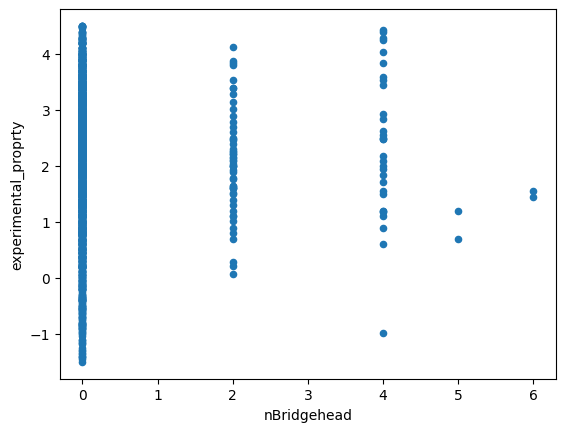

In [13]:
print(df['nBridgehead'].value_counts())
df.plot(kind = 'scatter', x = 'nBridgehead', y = 'experimental_proprty')

0    1918
1      48
2      27
3       5
6       1
5       1
Name: NdsCH, dtype: int64


<AxesSubplot:xlabel='NdsCH', ylabel='experimental_proprty'>

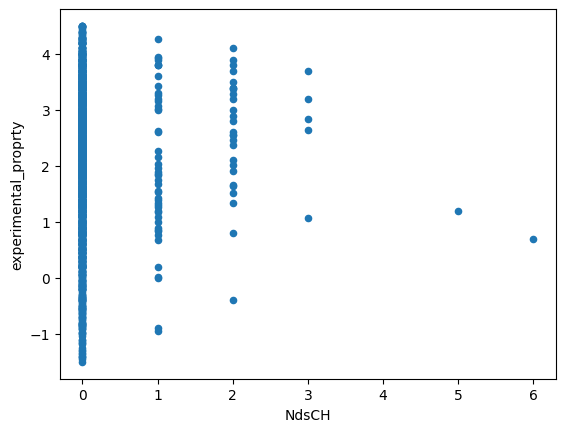

In [14]:
print(df['NdsCH'].value_counts())
df.plot(kind = 'scatter', x = 'NdsCH', y = 'experimental_proprty')

In [70]:
# Drop columns with constant values since they do not show meaningful patterns against other features.
df = df.drop(const_col,axis=1) 
df = df.drop(al_const_col,axis=1) 
df.shape

KeyError: "['MIF2' 'MIF3'] not found in axis"

#### For columns that contains floating points

In [16]:
const_col_fp, al_const_col_fp = check_const(float_col)

print('Columns with values are constant: ', const_col_fp)
print('Columns with values are almost the same: ', al_const_col_fp)

Columns with values are constant:  []
Columns with values are almost the same:  ['SsBr', 'SdNH', 'SdsN', 'StCH', 'SdsCH']


SsBr 1959
SdNH 1984
SdsN 1949
StCH 1993
SdsCH 1918


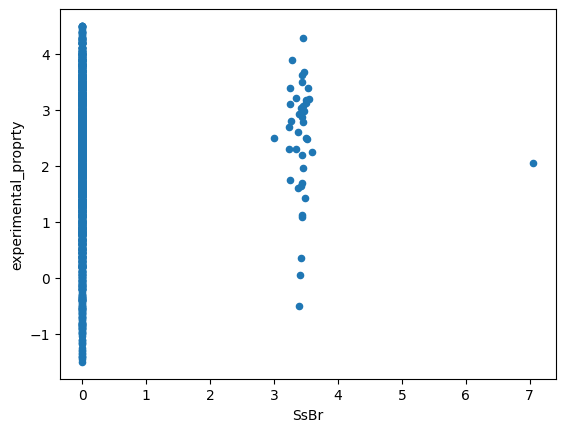

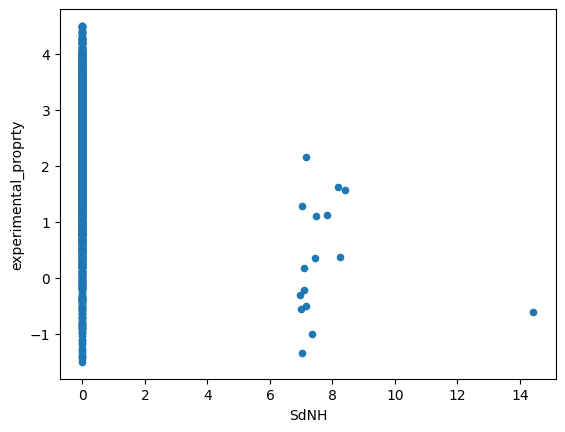

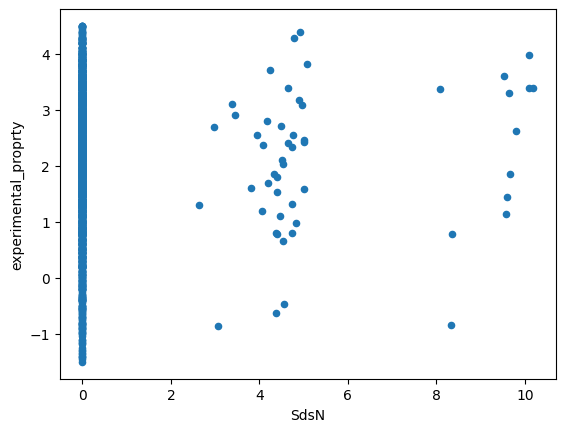

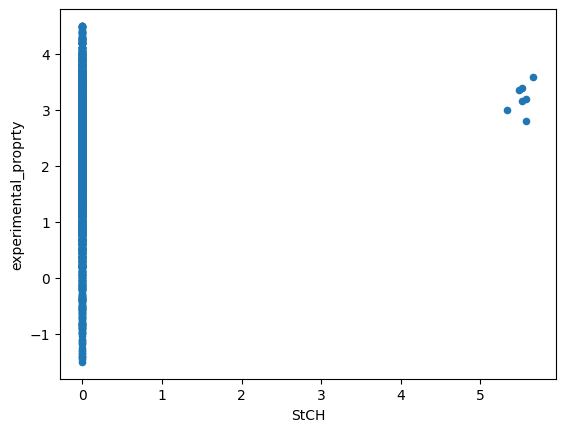

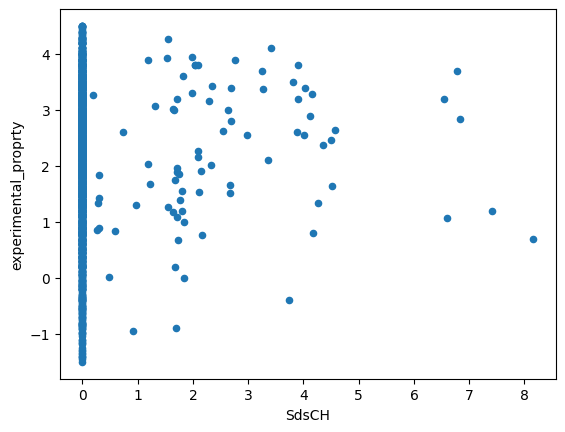

In [17]:
for i in al_const_col_fp:
    print(i, df[i].value_counts().max())
    df.plot(kind = 'scatter', x = i, y = 'experimental_proprty')

In [18]:
# Drop columns with constant values since they do not show meaningful patterns against other features.
df = df.drop(const_col_fp,axis=1) 
df = df.drop(al_const_col_fp,axis=1) 
df.shape

(2000, 543)

#### For columns that contains objects

PPENPINEAPLE42    1569
UHOVQNZJYSORNB      41
RCRMUKSWQWDMNL      17
ZUOUZKKEUPVFJK      15
NRTUTGBOQZQBMB      13
VHEGBLPHXSCODD      13
GALNGAIOIHBIMC      13
VFVXVRPTRGHSHB      12
WFGFEOLNELJISV      12
GOMNOOKGLZYEJT      12
Name: MS_enc, dtype: int64
Computation failed    100
45                     58
52                     57
54                     55
58                     55
62                     54
56                     52
55                     51
41                     51
53                     49
Name: MIF, dtype: int64
the_biggest    667
big            667
bigger         666
Name: SMIF, dtype: int64


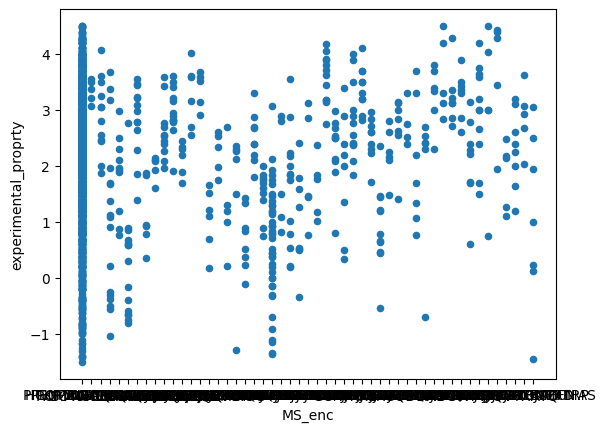

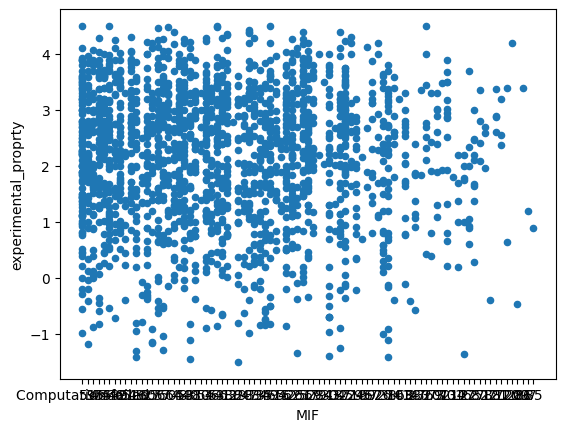

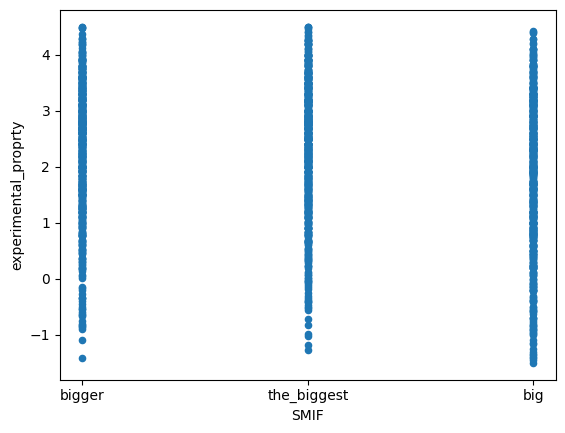

In [19]:
for i in object_col:
    print(df[i].value_counts()[0:10])
    df.plot(kind = 'scatter', x = i, y = 'experimental_proprty')

In [20]:
# Fix the value 'Computation failed'
df['MIF'].replace(['Computation failed'], np.nan,inplace=True)
print(df.isnull().sum().sum())
df['MIF'].astype('float64')
df['MIF'].replace(np.nan, df['MIF'].median(),inplace=True)

100


In [21]:
print(df['MIF'].value_counts())

49.0    100
45       58
52       57
54       55
58       55
       ... 
128       1
203       1
86        1
97        1
85        1
Name: MIF, Length: 85, dtype: int64


In [22]:
df.isnull().sum().sum() # Check if 'computational failed' values are fixed

0

### 1.3 Check and process columns with outliers

In [23]:
def check_outlier(df,summary,col_name,n=5):
    # df, summary (dataframe)
    # col_name (str): name of column we want to check
    # n (int): number of std away from the mean
    
    # return (boolean): whether this column contains any outliers (defined as x5 std.)
    
    std = summary[col_name]['std']
    mean = summary[col_name]['mean']
    
    count = 0 # number of data points classified as outliers
    isOutlier = False
    
    # nrows = df.shape[0]
    row_index = list(df.index)
    outlier_row = []
    for i in row_index:
        if abs((df[col_name][i] - mean)/std) > n: 
            count = count + 1
            if n >= 5:
                outlier_row.append(i)
    if count > 0:
        isOutlier = True
    
    return(isOutlier,count,outlier_row)

In [24]:
sample_size = df.shape[0]
check_outlier(df,summary,'WPath',n=10)

(True, 1, [1646])

In [25]:
numeric_col = df.select_dtypes(include=['int64','float64']).columns
with_outlier = []
outlier_count = []
row_toRemove = []
for col in numeric_col:
    isOutlier, count, outlier_row = check_outlier(df,summary,col,n=5)
    #if count > 10:
    #    print(col)
    if isOutlier == True:
        with_outlier.append(col)
        outlier_count.append(count) 
        row_toRemove.extend(outlier_row)

In [26]:
print(len(with_outlier))

422


In [27]:
print('Number of values that classify as outlier: ', len(row_toRemove))
row_toRemove = list(set(row_toRemove))
print('Number of distinct rows that contains outliers: ', len(row_toRemove))

Number of values that classify as outlier:  1514
Number of distinct rows that contains outliers:  236


In [28]:
df = df.drop(row_toRemove,axis=0) # drop row if the data point is outside 5*std from the mean of the feature

In [29]:
df.shape

(1764, 543)

                                       *********************************************

In [30]:
target = df['experimental_proprty']
df = df.drop(['experimental_proprty'],axis=1) # separate target column from the features list

In [31]:
df['MIF'].astype('float64')

0       49.0
1       59.0
2       37.0
4       55.0
6       66.0
        ... 
1995    68.0
1996    45.0
1997    56.0
1998    42.0
1999    50.0
Name: MIF, Length: 1764, dtype: float64

In [32]:
# list of columns with specific data type
integer_col = df.select_dtypes(include=['int64']).columns
float_col = df.select_dtypes(include=['float64']).columns
object_col = df.select_dtypes(include=['object']).columns

### 2.1 Analyze Correlations between Variables

In [33]:
# n! correlation calculation
def find_corr(x,y): 
    # x: column of a feature
    # y: column of another feature
    
    # corr_xy: correlation between two features
    
    corr_xy, _ = pearsonr(np.array(x), np.array(y))
    return(corr_xy)

def target_cor(target,col,a=0.75):
    # target: target variable
    # col: list of feature columns
    # a: range determine the 'correlated' relationship, default value set to be 0.75
    
    # corr_feature: list of features' names which correlated with target variable
    # corr: list of correration values
    
    corr_feature = []
    corr = []
    for c in col:
        if find_corr(target,df[c]) > a or find_corr(target,df[c]) < -a: # '>a' implies pos correlated, '<-a' implies neg correlated
            # print(c)
            # print(find_corr(target,df[c]))
            corr_feature.append(c)
            corr.append(find_corr(target,df[c]).round(4))
    return corr_feature, corr

#### Correlation between target variable 'experimental_proprty' and numerical features

In [34]:
# Target correlated to floating features
features_float, cor_float = target_cor(target,list(float_col),a=0.3)
print('Number of features correlated with target variable: ', len(features_float))
print(features_float)
print(cor_float)

Number of features correlated with target variable:  3
['FilterItLogS', 'BalabanJ', 'SLogP']
[-0.3645, -0.3483, 0.4147]


In [35]:
# Target correlated to integer features
features_int, cor_int = target_cor(target,list(integer_col),a=0.3)
print('Number of features correlated with target variable: ', len(features_int))
print(features_int)
print(cor_int)

Number of features correlated with target variable:  4
['nAcid', 'nBondsA', 'nAromBond', 'nAromAtom']
[-0.3183, 0.3081, 0.3081, 0.312]


In [36]:
## some linear regression?
## PCA

#### Correlation between numerical features

In [37]:
numeric_col = df.select_dtypes(include=['int64','float64']).columns
numeric_col.shape

(539,)

In [38]:
data = df[list(numeric_col)]
matrix = data.corr(method = 'pearson').round(4)

Number of features to drop:  254
Features with high correlation:  ['MPC4', 'Xp-7d', 'ATS8Z', 'SaasN', 'LabuteASA', 'ATS3pe', 'ATS0se', 'MPC7', 'SRW04', 'Sse', 'SRW10', 'ATSC6pe', 'bpol', 'ATS4pe', 'ATS0are', 'nBondsS', 'ATS0v', 'ATS2d', 'ATS8pe', 'ATS5i', 'ATS1se', 'MWC07', 'Xp-6d', 'ATS1are', 'WPol', 'NsCl', 'ATS0pe', 'AATSC5Z', 'nBondsKS', 'ATS3m', 'nBonds', 'Xp-3d', 'ATS2se', 'ATS2are', 'MWC03', 'TIC3', 'ATS4v', 'Sv', 'SRW06', 'ATS8m', 'ATSC4Z', 'Sp', 'ABCGG', 'ATS1m', 'nH', 'ATS7m', 'IC3', 'ATS4d', 'TIC5', 'ATS1p', 'MPC6', 'Xp-0dv', 'VMcGowan', 'ATS1pe', 'ATS7are', 'ATS0Z', 'MWC05', 'ATSC7se', 'TIC0', 'SRW07', 'ATS5m', 'MIF6', 'Xp-2dv', 'MIC4', 'Xp-4dv', 'SRW08', 'SZ', 'ATS7i', 'Si', 'Zagreb1', 'ATS2Z', 'ATS2pe', 'ATS5v', 'AATS1m', 'ATSC0p', 'ATS5pe', 'AATS3m', 'mZagreb2', 'n5Ring', 'SlogP_VSA7', 'SRW09', 'ATSC1Z', 'Xpc-6d', 'ATS3v', 'ATS8se', 'ATS3se', 'ATS8v', 'SssNH', 'MWC06', 'nHeavyAtom', 'ATS6are', 'ATS3p', 'ECIndex', 'Xp-5d', 'MWC10', 'StsC', 'AATSC1Z', 'piPC8', 'nC', 'ATSC5

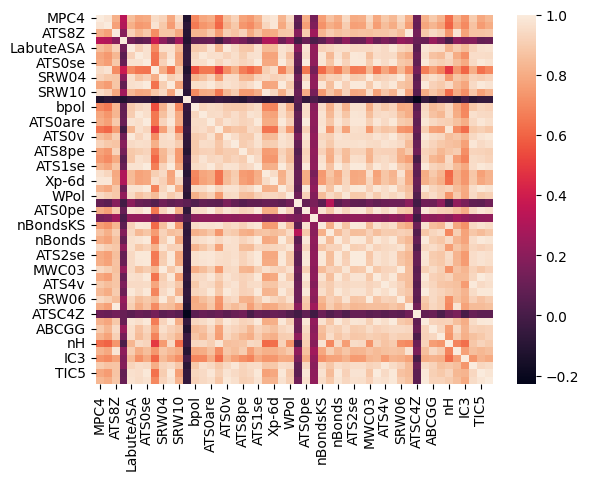

C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
# Create correlation matrix
matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('Number of features to drop: ', len(to_drop))
print('Features with high correlation: ', to_drop)

# Correlation heatmap of first 50 columns for checking
d = data[list(to_drop[0:50])]
matrix = d.corr(method = 'pearson').round(4)
sns.heatmap(matrix, annot=False)
plt.show()

# Drop features  from dataframe
data.drop(to_drop, axis=1, inplace=True)

In [40]:
numeric_col = [col for col in numeric_col if col not in to_drop]

In [41]:
len(numeric_col)

285

In [42]:
print(numeric_col)

['nHetero', 'nX', 'C2SP3', 'MPC5', 'ATS0i', 'NaasN', 'SsCH3', 'nCl', 'nFAHRing', 'SlogP_VSA6', 'AATS3d', 'ATSC6are', 'nHBDon', 'SddssS', 'ATS6m', 'nAcid', 'PEOE_VSA8', 'SsssCH', 'ATSC5dv', 'MPC9', 'AATS5v', 'ZMIC1', 'C2SP2', 'ATSC8v', 'MW2', 'MIC5', 'SMR_VSA2', 'nBondsA', 'nBondsKD', 'ATS1dv', 'PEOE_VSA6', 'AATS5pe', 'n9FaRing', 'SssS', 'AATSC5m', 'EState_VSA6', 'SRW03', 'AATS5i', 'n5HRing', 'NaaN', 'AATS1Z', 'ATSC3d', 'AATS5d', 'VSA_EState1', 'IC2', 'Xp-3dv', 'AATS5Z', 'ATS7pe', 'Xpc-5dv', 'ATSC0d', 'n10FaHRing', 'CIC1', 'ATSC1i', 'AATSC0dv', 'ATSC6Z', 'nF', 'ATS4m', 'EState_VSA2', 'ATSC4d', 'ATSC3i', 'ATSC4p', 'piPC5', 'AATS4m', 'IC4', 'NaaNH', 'ATS0m', 'ATSC1pe', 'VSA_EState9', 'AATSC0Z', 'SMR_VSA9', 'ATSC8dv', 'MIF4', 'VSA_EState4', 'PEOE_VSA13', 'SlogP_VSA10', 'ATSC6v', 'ATSC2i', 'n6aRing', 'AATS2Z', 'PEOE_VSA11', 'AATSC3m', 'nFRing', 'nO', 'ATSC7pe', 'AATSC1v', 'SRW05', 'EState_VSA8', 'Xpc-5d', 'NssssC', 'ATSC4m', 'AATSC5dv', 'C1SP3', 'SdO', 'nHRing', 'NtsC', 'EState_VSA9', 'AATS

In [43]:
data.shape

(1764, 285)

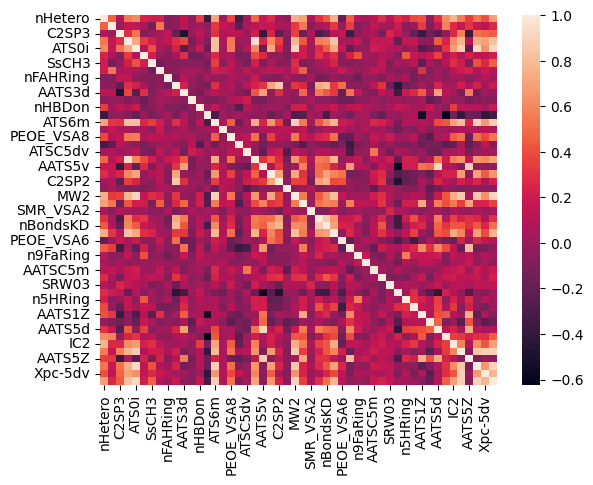

In [44]:
# Correlation heatmap for checking
d = data[list(numeric_col[0:50])]
matrix = d.corr(method = 'pearson').round(4)
sns.heatmap(matrix, annot=False)
plt.show()

### 2.2 Perform Dimensionality Reduction

#### PCA 

In [45]:
f = np.append(df.select_dtypes(include=['int64','float64']).columns,'MIF')

In [46]:
#data_target = pd.merge(target, df[list(df.select_dtypes(include=['int64','float64']).columns)], left_index=True,right_index=True)
#data_target.head()
target = np.array(target)
# features = np.array(df[list(df.select_dtypes(include=['int64','float64']).columns.append('MIF'))])
features = np.array(df[f])
print(target.shape,features.shape)

(1764,) (1764, 540)


In [47]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
print(target.shape,features.shape)

(1764,) (1764, 540)


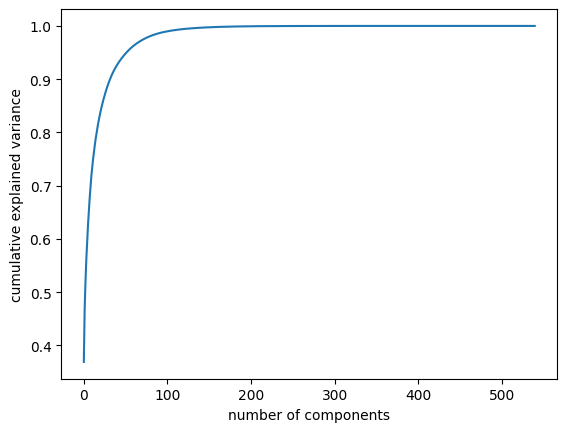

In [48]:
pca = PCA().fit(features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [49]:
variance = pca.explained_variance_ratio_

In [50]:
variance_90 = variance[0:40]
ratio = sum(variance_90)/sum(variance)
ratio # the model with 40 component principals explains 92.5% of variation

0.9248226975861832

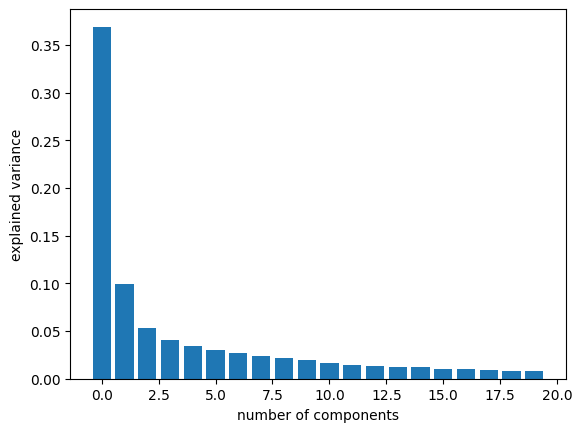

In [51]:
plt.bar(range(0,20), variance[0:20])
plt.xlabel('number of components')
plt.ylabel('explained variance');

In [52]:
data_pca = PCA(n_components=2).fit(features)
data_pca

PCA(n_components=2)

In [53]:
# The singular values corresponding to each of the selected components.
print(data_pca.singular_values_)

[592.90131154 307.76618138]


In [54]:
feature_pca = PCA(n_components=2).fit_transform(features)
feature_pca.shape

(1764, 2)

In [55]:
def plot_digits(PC, algo=""):
    with plt.style.context(("seaborn", "ggplot")):
        fig,ax = plt.subplots(1, figsize=(10, 6))

        points = ax.scatter(PC[:,0],PC[:,1], c=target, s=20, cmap="magma")
        fig.colorbar(points)

        plt.xlabel("dimension 1")
        plt.ylabel("dimension 2")
        plt.title(algo)
        plt.show()

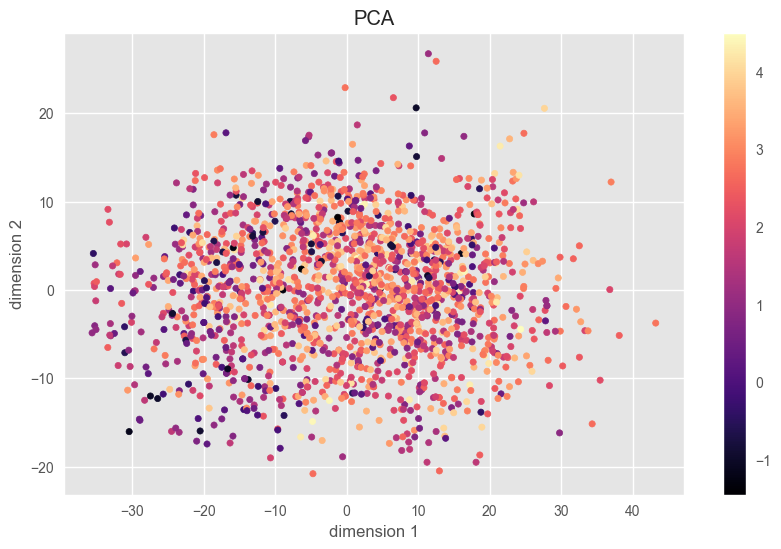

In [56]:
plot_digits(feature_pca, "PCA")

In [57]:
target = np.array(target)
# features = np.array(df[list(df.select_dtypes(include=['int64','float64']).columns)])
features_reduced = np.array(df[list(numeric_col)])
scaler = StandardScaler()
scaler.fit(features_reduced)
features_reduced = scaler.transform(features_reduced)
print(target.shape,features_reduced.shape)
pca_reduced = PCA(n_components=3).fit(features_reduced)

(1764,) (1764, 285)


In [58]:
feature_pca_reduced = pca_reduced.fit_transform(features_reduced)
feature_pca_reduced.shape

(1764, 3)

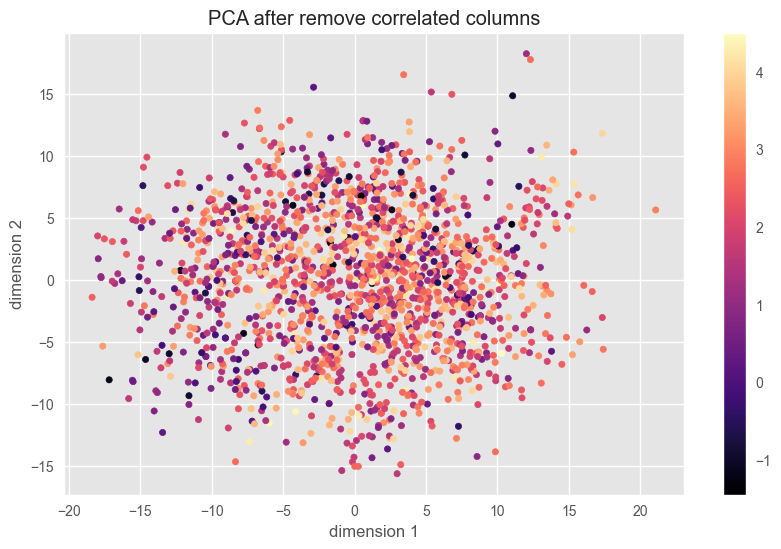

In [59]:
plot_digits(feature_pca_reduced, "PCA after remove correlated columns")

##### Regression on PCA

In [60]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(feature_pca_reduced, target, test_size=0.2)

In [62]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [63]:
Y_pred_test = model.predict(X_test)

In [64]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [ 0.02352536 -0.00101054  0.07590197]
Intercept: 2.1889623649050494
Mean squared error (MSE): 1.32
Coefficient of determination (R^2): 0.12


#### tSNE

In [65]:
tsne = manifold.TSNE(n_components=2,perplexity=50,random_state=11,n_iter=500)

In [66]:
feature_tsne = tsne.fit_transform(features_reduced)

C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


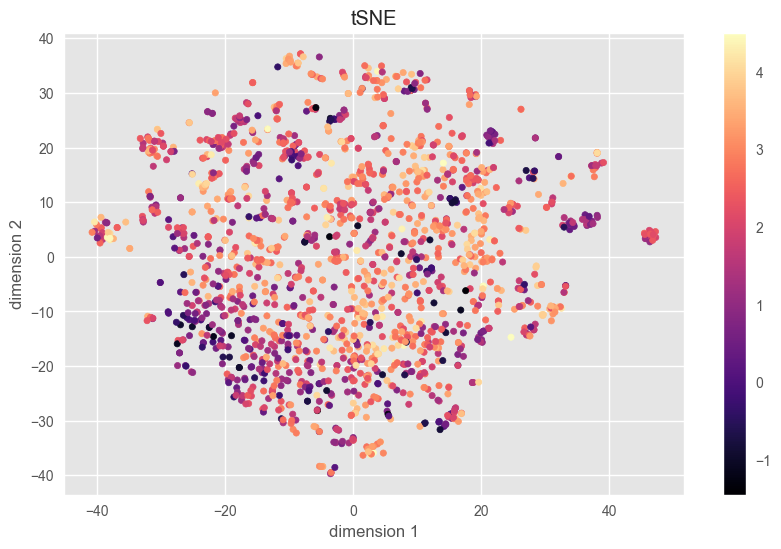

In [67]:
plot_digits(feature_tsne, "tSNE")

#### Isomap

In [68]:
isomap = manifold.Isomap(n_neighbors=10, n_components=2)
feature_isomap = isomap.fit_transform(features_reduced)

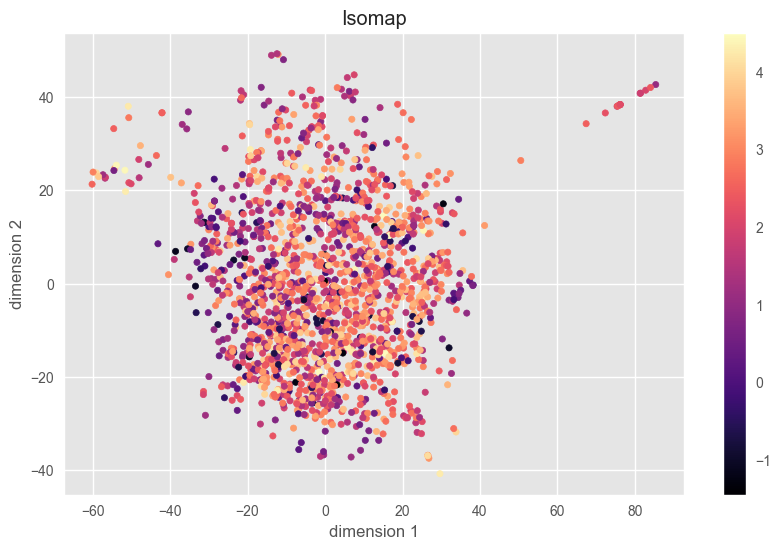

In [69]:
plot_digits(feature_isomap, "Isomap")